In [1]:
%load_ext autoreload
%autoreload 2%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import patches
import matplotlib.pyplot as plt
from astropy import cosmology
from astropy.io import fits
from astropy import table
import SAGA

In [3]:
cosmo = cosmology.FlatLambdaCDM(70.,0.3)

In [4]:
saga = SAGA.QuickStart(local_dir='../local_data/')
#'/path/to/saga/dropbox/folder', '/path/to/saga/local/folder')

SAGA `shared_dir` set to /Users/kadofong/work/surveys/saga/notebooks
SAGA `local_dir`  set to ../local_data/


In [5]:
saga.database["combined_base"].remote.path = "https://drive.google.com/uc?export=download&id=1WnGUfDCZwXEUsy4zgGFR1ez3ZE5DFtsB&confirm=t&uuid=d0f82ed0-6db5-4ca0-bb8f-6c54d44a17db"

saga.database["combined_base"].download(overwrite=False)

base = saga.object_catalog.load_combined_base_catalog()
base = saga.host_catalog.construct_host_query("paper3").filter(base)

In [33]:
clean = base[(base['REMOVE']==0)&base['is_galaxy']].to_pandas ().set_index('OBJID')
clean = clean.loc[clean['ZQUALITY']>=3]
clean = clean.loc[clean['gr_err'] < 1.] # \\ have all colors measured 
lowz = clean.loc[clean['SPEC_Z']<=0.2]
#clean = clean.loc[clean['g_mag']
#clean = clean.loc[clean['ri_err'] < 1.] # \\ have all colors measured 
#clean = clean.loc[clean['iz_err'] < 1.] # \\ have all colors measured 

In [211]:
lowz.shape

(34255, 105)

In [97]:
gama = fits.getdata('../../gama/local_data/StellarMassesLambdarv24.fits',1)
gama_phot = fits.getdata('../../gama/local_data/SersicCatSDSSv09.fits',1)

gama = table.Table(gama).to_pandas ()
gama = gama.set_index('CATAID')

gama_phot = table.Table(gama_phot).to_pandas ()
gama_phot = gama_phot.set_index('CATAID')

gama['GALMUE_r'] = gama_phot['GALMUE_r']
gama['gminusr'] = gama_phot['GALMAG_g'] - gama_phot['GALMAG_r']
gama['GALMAG_r'] = gama_phot['GALMAG_r']


In [30]:
logml = lambda gr: 1.65*gr - 0.66

In [46]:
g_matrix = [[0., 0., 0., 0.],
                [-0.900332, 3.97338, 0.774394, -1.09389],
                [3.65877, -8.04213, 11.0321, 0.781176],
                [-16.7457, -31.1241, -17.5553, 0],
                [87.3565, 71.5801, 0., 0.],
                [-123.671, 0, 0, 0]]
g_matrix = np.asarray(g_matrix)

r_matrix = [[0.,0.,0.,0.],
            [-1.61294, 3.81378, -3.56114, 2.47133],
            [9.13285, 9.85141, -5.1432, -7.02213],
            [-81.8341, -30.3631, 38.5052, 0.0],
            [250.732, -25.0159, 0.0, 0.0],
            [-215.377, 0.0, 0.0, 0.0]]
r_matrix = np.asarray(r_matrix)
            
kcorr_d = {'g':g_matrix,'r':r_matrix}

In [47]:
def kcorrect ( z, gr, bandpass ):
    if isinstance(z, float):
        kcorr_est = 0.
    else:
        kcorr_est = np.zeros(z.shape)
    for x_idx in range(5):
        for y_idx in range(4):
            coeff = kcorr_d[bandpass][x_idx, y_idx]
            term = coeff * z**x_idx * gr**y_idx
            kcorr_est += term
    return kcorr_est

In [48]:
kcorr_g = kcorrect ( lowz['SPEC_Z'], lowz['gr'], 'g' )
kcorr_r = kcorrect ( lowz['SPEC_Z'], lowz['gr'], 'r' )
gr_restframe = lowz['g_mag'] + kcorr_g - (lowz['r_mag'] + kcorr_r)
M_g = lowz['Mr'] + gr_restframe
zp_g = 5.11
loglum_g = (M_g-zp_g)/-2.5
logsmass = logml(gr_restframe) + loglum_g

In [52]:
midpts = lambda x: 0.5*(x[1:]+x[:-1])

In [197]:


lowz['gr_restframe'] = gr_restframe
gama['gr_restframe'] = gama['absmag_g'] - gama['absmag_r']
lowz['logmstar'] = logsmass

# \\ let's also recompute the GAMA
# \\ stellar masses "consistently" (modulo photometry)
kcorr_g_gama = kcorrect ( gama['Z'], gama['gminusr'], 'g')
kcorr_r_gama = kcorrect ( gama['Z'], gama['gminusr'], 'r')
M_g_gama = gama['gminusr'] + gama['GALMAG_r'] - kcorr_g_gama - cosmo.distmod ( gama['Z'].values ).value
loglum_g_gama = (M_g_gama-zp_g)/-2.5
gr_restframe_gama = gama['gminusr'] + kcorr_g_gama - kcorr_r_gama
logsmass_recomputed = logml(gr_restframe_gama) + loglum_g_gama

gama['logmstar_recomp'] = logsmass_recomputed

/var/folders/py/1g64k0fx3rd03lcwckrdjbt80000gn/T/ipykernel_27928/1748532262.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lowz['gr_restframe'] = gr_restframe
/var/folders/py/1g64k0fx3rd03lcwckrdjbt80000gn/T/ipykernel_27928/1748532262.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lowz['logmstar'] = logsmass


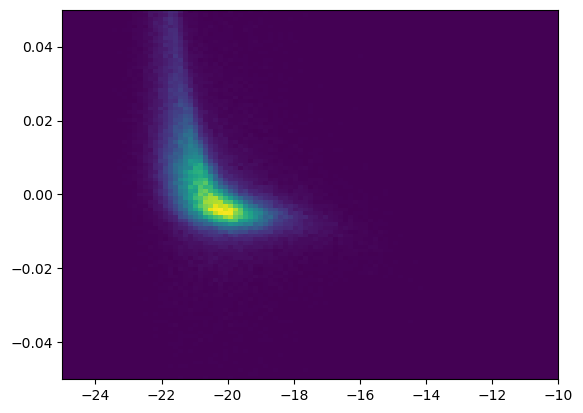

In [204]:
_=plt.hist2d ( gama['absmag_g'], (M_g_gama - gama['absmag_g'])/gama['absmag_g'], bins=[np.linspace(-25,-10, 100), np.linspace(-.05,.05,100)] )



In [ ]:
# \\ estimate mass completeness
rlim = 20.75
minobs_logsmass = logsmass - 0.4*(-lowz['r_mag'] + rlim)

# \\ min obs stellar mass (z)
dz = 0.01
zbins = np.arange(0.,.2,dz)
completeness = np.zeros([1, zbins.size, 3])
for idx,zb in enumerate(zbins):
    mask = abs(lowz['SPEC_Z'] - zb)<dz
    completeness[0,idx] = np.nanquantile(minobs_logsmass.loc[mask],[.5,.8,.9])



Text(0, 0.5, '$\\log_{10}(M_\\bigstar/M_\\odot)$')

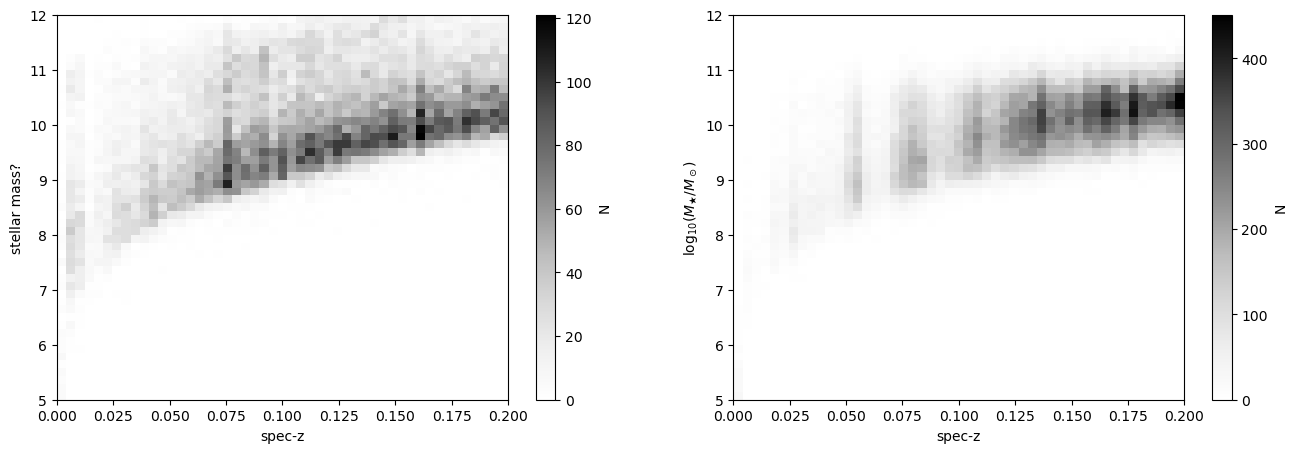

In [156]:
fig, axarr = plt.subplots(1,2,figsize=(16,5))

ax = axarr[0]
out=ax.hist2d ( lowz['SPEC_Z'], logsmass, bins=[np.linspace(0.,.2,50), np.linspace(5.,12.,50)], cmap='Greys')
plt.colorbar(out[-1], ax=ax, label="N")
#ax.plot ( zbins, completeness[0,:,1] )
ax.set_xlabel("spec-z")
ax.set_ylabel("stellar mass?")

ax = axarr[1]
out=ax.hist2d ( gama['Z'], gama['logmstar'], bins=[np.linspace(0.,.2,50), np.linspace(5.,12.,50)], cmap='Greys')
plt.colorbar(out[-1], ax=ax, label="N")
ax.set_xlabel("spec-z")
ax.set_ylabel(r"$\log_{10}(M_\bigstar/M_\odot)$")

/var/folders/py/1g64k0fx3rd03lcwckrdjbt80000gn/T/ipykernel_27928/2463191002.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lowz['gr_restframe'] = gr_restframe
/var/folders/py/1g64k0fx3rd03lcwckrdjbt80000gn/T/ipykernel_27928/2463191002.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lowz['logmstar'] = smass


1516
1501


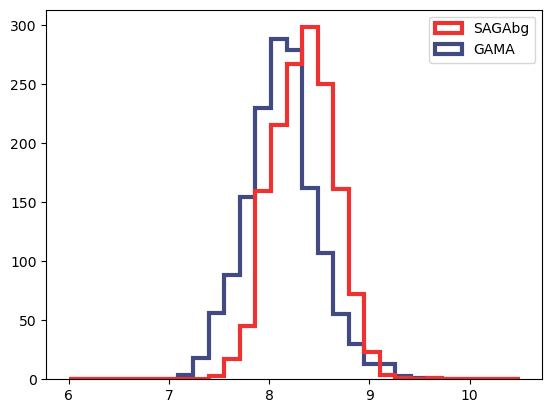

In [187]:
zmidpt = 0.025
zstep = 0.025

mmidpt = -16 #8.5
mstep = 1. #0.25

zkeys = ['SPEC_Z', 'Z']
colorkeys = ['gr_restframe','gr_restframe']
obskeys = ['gr','gminusr']
masskeys = ['logmstar','logmstar']
absmagkeys = ['Mr','absmag_r']
magkeys = ['r_mag','GALMAG_r']

cc_l = ['#ee3131','#414a83']
zorder_l = [1,0]
survey_l = ['SAGAbg','GAMA']

for idx,df in enumerate([lowz, gama]):
    zkey = zkeys[idx]
    zslice = abs(df[zkey]-zmidpt) < zstep
    mslice = abs(df[absmagkeys[idx]] - mmidpt) < mstep 

    plt.hist ( df.loc[zslice&mslice, masskeys[idx]], 
              #bins = np.linspace(14.,24.,30),
              #bins=np.linspace(-0.2,1.,30), 
              bins=np.linspace(6.,10.5,30),
              histtype='step',
              label=survey_l[idx],
              lw=3, color=cc_l[idx], zorder=zorder_l[idx], )
              #density=True)
    totnum = (zslice&mslice).sum()
    print(totnum)
    
plt.legend ()

In [128]:
mbins = np.linspace(6,10.5,6)
mbins_midpts = midpts(mbins)
mstep = abs(np.mean(np.diff(mbins)))/2.

mrc_bins = [ np.linspace(13.5,21,100), np.linspace(-0.2,1.5,100) ]

surveys = ['SAGA','GAMA']
dfs = [lowz, gama]
colorkeys = ['gr', 'gminusr']
magkeys = ['r_mag','GALMAG_r']
absmagkeys = ['Mr', 'absmag_r']
zkeys = ['SPEC_Z', 'Z']
masskeys = ['logmstar','logmstar']
colors = ['tab:green','tab:red']

for gdx in range(2):
    name = surveys[gdx]
    df = dfs[gdx]
    for zlim in [0.2, 0.5]:
        zbins = np.linspace(0.,zlim,5)
        zbins_midpts = midpts(zbins)
        zstep = np.mean(np.diff(zbins))/2.

        fig, f_axarr = plt.subplots ( zbins.size-1, mbins.size-1,
                                     figsize=(5.*(mbins.size-1),4.*(zbins.size-1)) )
        for hdx in range(len(zbins_midpts)):
            axarr = f_axarr[hdx]
            zslice = abs(df[zkeys[gdx]] - zbins_midpts[hdx]) < zstep
            for idx,ax in enumerate(axarr):
                midpt = mbins_midpts[idx]
                mslice = abs(df[masskeys[gdx]] - midpt) < mstep
                mslice &= zslice#df['SPEC_Z']<=.2

                ngal = mslice.sum()
                if ngal == 0:
                    fig.delaxes(ax)
                    continue



                if ngal > 100:
                    ax.hist2d ( df.loc[mslice,magkeys[gdx]], df.loc[mslice, colorkeys[gdx]], 
                               bins=mrc_bins, cmap='Greys' )
                else:
                    ax.scatter ( df.loc[mslice,magkeys[gdx]], df.loc[mslice, colorkeys[gdx]], 
                                color='grey', s=1) 
                ax.text ( 0.025, 0.975, r'''$%.1f<{\rm M_\star/M_\odot}\leq%.1f$ AND $%.2f<z\leq%.2f$
        N=%i''' % (mbins[idx],mbins[idx+1],zbins[hdx],zbins[hdx+1], ngal), transform=ax.transAxes,
                          va='top', )

                # \\ cosmetics
                ax.set_xlabel ( r'm$_{\rm r}$ [obsframe]' )
                ax.set_ylabel ( r'g - r [obsframe]')

                ax.set_xlim(13.5, 21.)
                ax.set_ylim(-0.2, 1.5)
                
                ax.axhline(0.85, color='C0', ls='--')
                ax.axvline(20.75, color='C0', ls='--')
                ax.axvline(19.6, color='r', ls='--')


        plt.tight_layout ()
        plt.savefig(f'../figures/exploration/{name}_masscut_zlim{zlim*10:.0f}.png')
        plt.close()


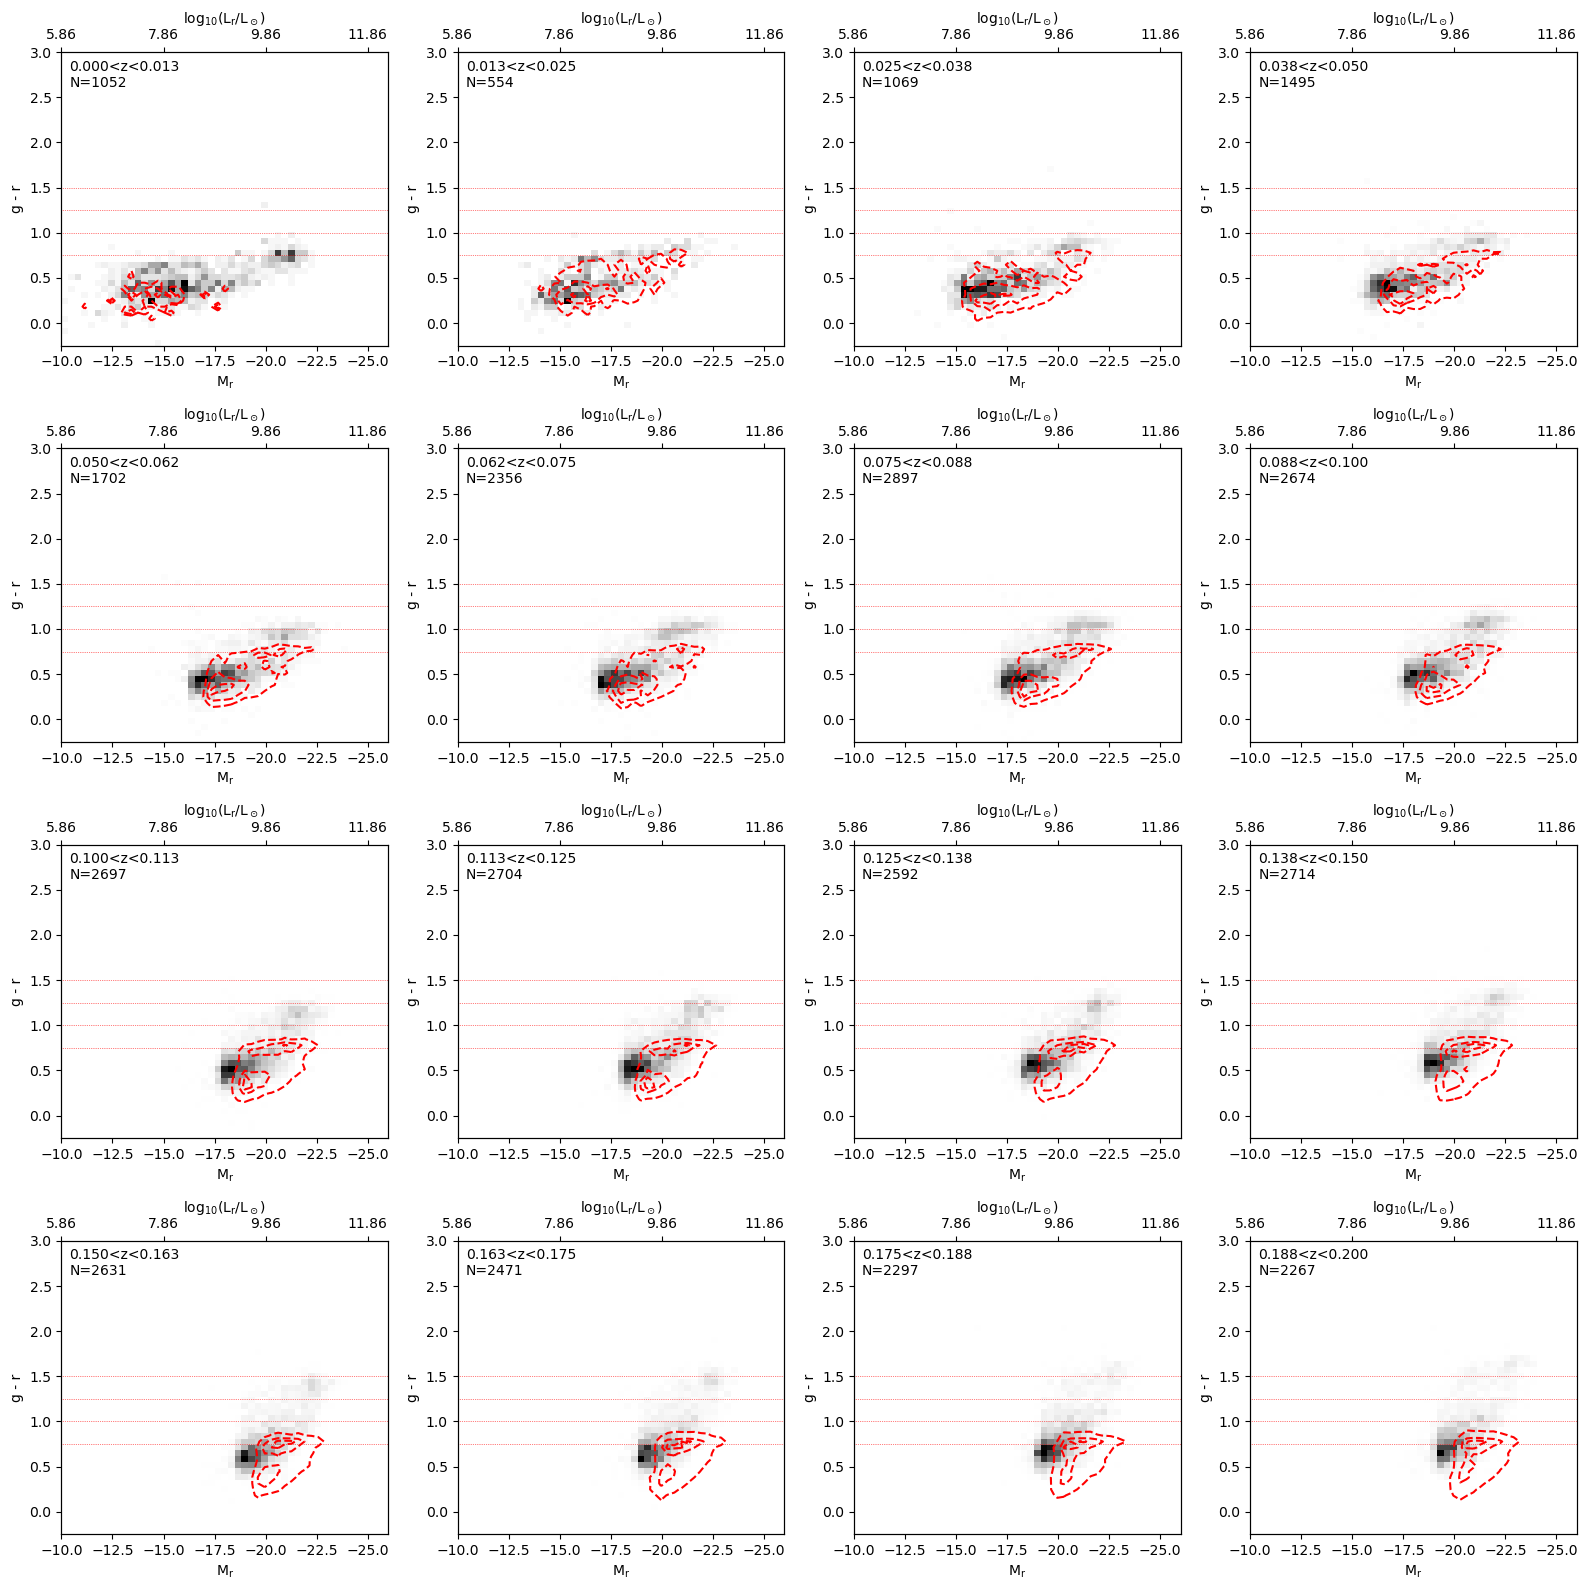

In [55]:
fig, axarr = plt.subplots(4,4, figsize=(16,16))                          
f_axarr = axarr.flatten ()
zbins = np.linspace(0.,.2,17)
step = np.mean(np.diff(zbins))
zp = 4.65

bins_l = [ np.linspace(-26,-10,50), np.linspace(-0.25,3,50) ]
for idx, zb in enumerate(zbins[:-1]):
    ax = f_axarr[idx]    
    
    zslice = abs(lowz['SPEC_Z']-(zb+step/2.)) <= step/2.
    ax.hist2d ( lowz.loc[zslice,'Mr'], gr_restframe.loc[zslice], bins=bins_l, cmap='Greys')
    
    # \\ add GAMA contours
    zslice_gama = abs(gama['Z']-(zb+step/2.)) <= step/2.
    out = np.histogram2d ( gama.loc[zslice_gama,'absmag_r'], 
                           gama.loc[zslice_gama,'absmag_g'] - gama.loc[zslice_gama,'absmag_r'], 
                           bins=bins_l)

    levels = np.quantile(out[0][out[0]>0],[.8**2,.95**2,.99**2])
    ax.contour( midpts(out[1]),midpts(out[2]), out[0].T, levels=levels, colors='r',linestyles='--')

    ax.text ( 0.025, .975, f'''{zbins[idx]:.3f}<z<{zbins[idx+1]:.3f}
N={zslice.sum()}''', transform=ax.transAxes, ha='left', va='top' )
    ax.set_xlabel(r'M$_{\rm r}$')
    ax.set_ylabel(r'g - r')
    ax.set_xlim(ax.get_xlim()[::-1])
    
    twiny = ax.twiny()
    twiny.set_xticks ( (ax.get_xticks()-zp)/-2.5 ) # log10(L_r)
    twiny.set_xlim((np.asarray(ax.get_xlim())-zp)/-2.5 ) 
    twiny.set_xlabel ( r'$\log_{10}(\rm L_r/L_\odot)$')
    
    for hline in [.75, 1.,1.25,1.5]:
        ax.axhline(hline, color='r', ls=':', lw=0.5)
    ax.set_rasterization_zorder(1)


plt.tight_layout ()
#plt.savefig('../figures/exploration/cmd_hist.png')